# Main figures in "Top-down connection in hierarchical sparse coding" for the CFD database
https://arxiv.org/abs/2002.00892

In [86]:
from SPC_2L.DataTools import DataBase, to_img, show
import pickle
from SPC_2L.Network import LayerPC, Network
from SPC_2L.Coding import ML_FISTA, ML_Lasso
import torch.nn.functional as f
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import torch
from torchvision.transforms import ToTensor,Compose
from SPC_2L.DataTools import LCN, whitening, z_score, mask, to_cuda, norm
from torch.utils.data import DataLoader

## Tools, parameters and database

In [87]:
def reconstruction(Net,gamma):
    reco = [None] * (Net.nb_layers)
    for i in range(Net.nb_layers-1,-1,-1):
        reco[i] = gamma[i]
        for j in range(i, -1, -1):
            reco[i] = Net.layers[j].backward(reco[i])
    return reco

In [88]:
data_path = '../../DataSet/CF_DB_testing'

LCN_params = {'kernel_size':11,'sigma':0.5, 'rgb':True} # Local contrast normalization parameters

mask_params={'n': 10} # mask parameters

whitening_params={'f_0':0.5,'n':2} # Whitening parameters

Data_load_param = { 'batch_size': 10,
                    'do_LCN': True,
                    'LCN_params': LCN_params,
                    'do_mask': True,
                    'mask_params': mask_params,
                    'do_whitening': True,
                    'whitening_params': whitening_params,
                    'do_z_score': True,
                    'return_idx': False
                  }

Facedata = DataBase('from_ImageFolder', data_path, img_size=(100,124),reshaped_size=(120,171),**Data_load_param, shuffle=True)

save = False #### Use to re-run the entire simulation : TAKE HOURS. Use False to load previous simulation

range_b = [0,1] ## b=0 --> HiLa, b=1 --> 2L_SPC
range_lbda1 = [0.3 + i*0.1 for i in range(5)] ## range of tested lbda1
range_lbda2 = [1.0 + i*0.2 for i in range(5)] ## range of tested lbda2

model_name_list_l1_b0 = ['CFD_[{0:0.1f},1.8]_b={1:0.0f}'.format(lbda1,0) for lbda1 in range_lbda1]
model_name_list_l2_b0 = ['CFD_[0.5,{0:0.1f}]_b={1:0.0f}'.format(lbda2,0) for lbda2 in range_lbda2]

model_name_list_l1_b1 = ['CFD_[{0:0.1f},1.8]_b={1:0.0f}'.format(lbda1,1) for lbda1 in range_lbda1]
model_name_list_l2_b1 = ['CFD_[0.5,{0:0.1f}]_b={1:0.0f}'.format(lbda2,1) for lbda2 in range_lbda2]


cmap1=plt.get_cmap('tab20c')
cmap2=plt.get_cmap('tab20b')

## Save == True: Wrapping all  the exploration space in one file

In [89]:
exp_list = {'CFD_lbda1' : (model_name_list_l1_b0, model_name_list_l1_b1),
          'CFD_lbda2' : (model_name_list_l2_b0, model_name_list_l2_b1)
         }

if save == True : 
    for exp_idx, exp_name in enumerate(exp_list.keys()):
        print('Exp {0} : {1}'.format(exp_idx,exp_name))
        file_to_save = 'Savings/CFD/' + str(exp_name) + '.pkl'
        
        Layer_wise_loss_SDPC = np.zeros((len(range_b),len(model_name_list_l1_b0), 2))
        it_SDPC = np.zeros((len(range_b),len(model_name_list_l1_b0)))
        all_L2_loss = np.zeros((len(range_b),len(model_name_list_l1_b0), 2))
        all_L1_loss = np.zeros((len(range_b),len(model_name_list_l1_b0), 2))

        for idx_b, b in enumerate(range_b):
        
            for idx_model, model_name in enumerate(exp_list[exp_name][idx_b]):
                print(model_name)
                path = 'Savings/CFD/' + model_name +'.pkl'

                with open(path, 'rb') as file:
                    out = pickle.load(file)
                Net = out['Net']
                print(Net.layers[0].b)
                Loss = out['Loss']
                Pursuit = out['Pursuit'] 
                all_error = [0] * (Net.nb_layers)
                all_it = 0
                all_Loss = [0] * (Net.nb_layers)
                penalty = [None] * (Net.nb_layers)
                all_penalty = [0] * (Net.nb_layers)
                for idx_batch, data in enumerate(Facedata.data):
                    batch = data[0].cuda()
                    if idx_batch>20:
                        break
                    gamma, it, Loss_G, delta = Pursuit.coding(batch)
                    reco = reconstruction(Net,gamma)
                    error = [(((data[0].cuda() - reco[i]).pow(2).sum())/(data[0].cuda().pow(2).sum())) for i in range(Net.nb_layers)]
                    for i in range(Net.nb_layers):
                        all_Loss[i] += Loss.F(batch,gamma,i, do_feedback=False).div(batch.size()[0])

                    penalty = [Loss.lambdas[i]*gamma[i].abs().sum() for i in range(Net.nb_layers)]

                    for i in range(Net.nb_layers):
                        all_error [i] += error[i]
                    for i in range(Net.nb_layers):
                        all_penalty[i] += penalty[i]
                    all_it += it        

                print('idx_batch',idx_batch)

                for i in range(Net.nb_layers):
                    all_error[i] /= ((idx_batch+1)*batch.size(0))
                for i in range(Net.nb_layers):
                    all_Loss[i] /= ((idx_batch+1))    
                for i in range(Net.nb_layers):
                    all_penalty[i] /= ((idx_batch+1)*batch.size(0))    
                all_it /= (idx_batch+1)
                tot_loss = 0
                for i in range(Net.nb_layers):
                    tot_loss += all_Loss[i]+all_penalty[i]
                    Layer_wise_loss_SDPC[idx_b, idx_model,i]=all_Loss[i]+all_penalty[i]
                    all_L2_loss[idx_b, idx_model,i] = all_Loss[i]
                    all_L1_loss[idx_b, idx_model, i] = all_penalty[i]
                it_SDPC[idx_b, idx_model] = all_it 
            res_SDPC = {'loss': Layer_wise_loss_SDPC,
                      'it': it_SDPC,
                        'L2_loss':all_L2_loss,
                        'L1_loss':all_L1_loss}
            with open(file_to_save, 'wb') as file:
                pickle.dump(res_SDPC, file, pickle.HIGHEST_PROTOCOL)
        else : 
            with open(file_to_save, 'rb') as file:
                res_SDPC = pickle.load(file)



## Fig 2

In [90]:
with open('Savings/CFD/CFD_lbda1.pkl', 'rb') as file:
        res_exp_lbda1 = pickle.load(file)
        
with open('Savings/CFD/CFD_lbda2.pkl', 'rb') as file:
        res_exp_lbda2 = pickle.load(file)



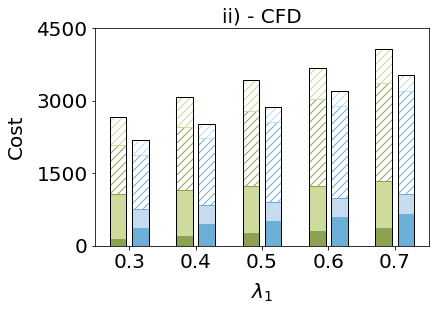

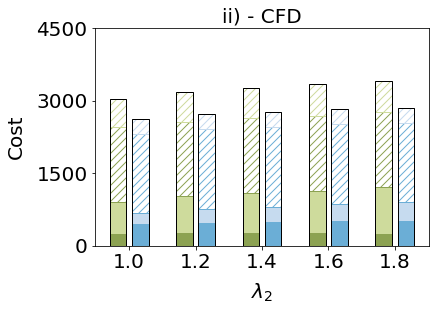

In [91]:
save_fig = True
width = 0.75 
fontsize = 20
## Plotting reconsctruction error when increasing lbda1
N = res_exp_lbda1['loss'].shape[1]
position_SDPC = [2 + 3*i for i in range(N)] 
position_HiLa = [1 + 3*i for i in range(N)] 
SPDC_l2norm_L1_lbda1 = res_exp_lbda1['L2_loss'][1,:,0]
SPDC_l2norm_L2_lbda1 = res_exp_lbda1['L2_loss'][1,:,1]
SPDC_l1norm_L1_lbda1 = res_exp_lbda1['L1_loss'][1,:,0]
SPDC_l1norm_L2_lbda1 = res_exp_lbda1['L1_loss'][1,:,1]

HiLa_l2norm_L1_lbda1 = res_exp_lbda1['L2_loss'][0,:,0]
HiLa_l2norm_L2_lbda1 = res_exp_lbda1['L2_loss'][0,:,1]
HiLa_l1norm_L1_lbda1 = res_exp_lbda1['L1_loss'][0,:,0]
HiLa_l1norm_L2_lbda1 = res_exp_lbda1['L1_loss'][0,:,1]


fig = plt.figure()

p_SDPC__l2norm_L1 = plt.bar(position_SDPC, SPDC_l2norm_L1_lbda1,
                    width, color=cmap1(1))#, edgecolor=cmap2(0))
p_SDPC_l2norm_L2 = plt.bar(position_SDPC, SPDC_l2norm_L2_lbda1,
                    width, color=cmap1(3),bottom= SPDC_l2norm_L1_lbda1)#, edgecolor=cmap2(0),
                   
p_SDPC_l1norm_L1= plt.bar(position_SDPC, SPDC_l1norm_L1_lbda1,
                    width, bottom=SPDC_l2norm_L2_lbda1+SPDC_l2norm_L1_lbda1,color='white'
                           ,edgecolor=cmap1(1), hatch='///')#, color=cmap1(3), edgecolor=cmap2(0),

p_SDPC_l1norm_L2 = plt.bar(position_SDPC, SPDC_l1norm_L2_lbda1,
                    width, bottom=SPDC_l2norm_L2_lbda1+SPDC_l2norm_L1_lbda1+SPDC_l1norm_L1_lbda1,
                           color='white',edgecolor=cmap1(3), hatch='///')#, color=cmap1(3), edgecolor=cmap2(0),


p_edges_SDPC = plt.bar(position_SDPC, SPDC_l2norm_L1_lbda1+SPDC_l2norm_L2_lbda1+SPDC_l1norm_L2_lbda1+SPDC_l1norm_L1_lbda1,
                    width,color='none',edgecolor='black')

p_HiLa_l2norm_L1 = plt.bar(position_HiLa, HiLa_l2norm_L1_lbda1, width ,color=cmap2(5))
p_HiLa_l2norm_L2 = plt.bar(position_HiLa, HiLa_l2norm_L2_lbda1, width, color=cmap2(7),
                   bottom=HiLa_l2norm_L1_lbda1)
p_HiLa_l1norm_L1 = plt.bar(position_HiLa, HiLa_l1norm_L1_lbda1, width, color='white',
                   bottom=HiLa_l2norm_L1_lbda1+HiLa_l2norm_L2_lbda1, edgecolor=cmap2(5),
                    hatch='///')
p_HiLa_l1norm_L2 = plt.bar(position_HiLa, HiLa_l1norm_L2_lbda1, width, color='white',
                   bottom=HiLa_l2norm_L1_lbda1+HiLa_l2norm_L2_lbda1+HiLa_l1norm_L1_lbda1,
                    edgecolor=cmap2(7), hatch='///')

p_edges_HiLa = plt.bar(position_HiLa, HiLa_l2norm_L1_lbda1+HiLa_l2norm_L2_lbda1+HiLa_l1norm_L2_lbda1+HiLa_l1norm_L1_lbda1,
                    width,color='none',edgecolor='black')


plt.ylabel('Cost', fontsize=fontsize, labelpad=10)
plt.title('ii) - CFD', fontsize=fontsize)
#plt.title('Evolution Layer-wise loss in SDPC and Hi-La network \n when varying the second layer sparsity')
xticks_position = [1.5 +3*i for i in range(N)]
plt.xlabel(r"$\lambda_{1}$", fontsize=fontsize, labelpad=10)
plt.yticks([0,1500,3000,4500],fontsize=fontsize)
plt.xticks(xticks_position,['{0:0.1f}'.format(lbda1) for lbda1 in range_lbda1]
           , fontsize=fontsize)

#plt.legend((p_SDPC_l2norm_L1, p_HiLa_l2norm_L1, p_SDPC_l2norm_L2, p_HiLa_l2norm_L2,
#           p_SDPC_l1norm_L1, p_HiLa_l1norm_L1, p_SDPC_l1norm_L2,  p_HiLa_l1norm_L2), 
#          ('2L-SPC - '+ r'$1^{st}$'+' layer  - 'r'$\ell_2$' +' term',
#           'Hi-La - '+ r'$1^{st}$'+' layer  - 'r'$\ell_2$' +' term',
#           '2L-SPC - '+ r'$2^{nd}$'+' layer  - 'r'$\ell_2$' +' term', 
#           'Hi-La - '+ r'$2^{nd}$'+' layer  - 'r'$\ell_2$' +' term',
#           '2L-SPC - '+ r'$1^{st}$'+' layer  - 'r'$\ell_1$' +' term',
#           'Hi-La - '+ r'$1^{st}$'+' layer  - 'r'$\ell_1$' +' term',
#           '2L-SPC - '+ r'$2^{nd}$'+' layer  - 'r'$\ell_1$' +' term',
#           'Hi-La - '+ r'$2^{nd}$'+' layer  - 'r'$\ell_1$' +' term'),
#          ncol=4, 
#           bbox_to_anchor=(1, 0.5), 
#           loc='center',
#           fontsize=fontsize)

if save_fig:
    plt.savefig('Savings/Fig/Fig2/Fig2-a-ii.pdf', bbox_inches = 'tight', pad_inches = 0.1, format='pdf')
    
plt.show()


## Plotting reconsctruction error when increasing lbda2


fig = plt.figure()

N = res_exp_lbda2['loss'].shape[1]
position_SDPC = [2 + 3*i for i in range(N)] 
position_HiLa = [1 + 3*i for i in range(N)] 

SPDC_l2norm_L1_lbda2 = res_exp_lbda2['L2_loss'][1,:,0]
SPDC_l2norm_L2_lbda2 = res_exp_lbda2['L2_loss'][1,:,1]
SPDC_l1norm_L1_lbda2 = res_exp_lbda2['L1_loss'][1,:,0]
SPDC_l1norm_L2_lbda2 = res_exp_lbda2['L1_loss'][1,:,1]

HiLa_l2norm_L1_lbda2 = res_exp_lbda2['L2_loss'][0,:,0]
HiLa_l2norm_L2_lbda2 = res_exp_lbda2['L2_loss'][0,:,1]
HiLa_l1norm_L1_lbda2 = res_exp_lbda2['L1_loss'][0,:,0]
HiLa_l1norm_L2_lbda2 = res_exp_lbda2['L1_loss'][0,:,1]


p_SDPC_l2norm_L1 = plt.bar(position_SDPC, SPDC_l2norm_L1_lbda2,
                    width, color=cmap1(1))#, edgecolor=cmap2(0))
p_SDPC_l2norm_L2 = plt.bar(position_SDPC, SPDC_l2norm_L2_lbda2,
                    width, color=cmap1(3),bottom= SPDC_l2norm_L1_lbda2)#, edgecolor=cmap2(0),
                   
p_SDPC_l1norm_L1= plt.bar(position_SDPC, SPDC_l1norm_L1_lbda2,
                    width, bottom=SPDC_l2norm_L2_lbda2+SPDC_l2norm_L1_lbda2,color='white'
                           ,edgecolor=cmap1(1), hatch='///')#, color=cmap1(3), edgecolor=cmap2(0),
                   #bottom= SPDC_L1_lbda2)

p_SDPC_l1norm_L2 = plt.bar(position_SDPC, SPDC_l1norm_L2_lbda2,
                    width, bottom=SPDC_l2norm_L2_lbda2+SPDC_l2norm_L1_lbda2+SPDC_l1norm_L1_lbda2,
                           color='white',edgecolor=cmap1(3), hatch='///')#, color=cmap1(3), edgecolor=cmap2(0),
                #bottom= SPDC_L1_lbda2)
#plt.hist(gaussian_numbers, edgecolor='black', linewidth=1.2)

p_edges_SDPC = plt.bar(position_SDPC, SPDC_l2norm_L1_lbda2+SPDC_l2norm_L2_lbda2+SPDC_l1norm_L2_lbda2+SPDC_l1norm_L1_lbda2,
                    width,color='none',edgecolor='black')

p_HiLa_l2norm_L1 = plt.bar(position_HiLa, HiLa_l2norm_L1_lbda2, width ,color=cmap2(5))
p_HiLa_l2norm_L2 = plt.bar(position_HiLa, HiLa_l2norm_L2_lbda2, width, color=cmap2(7),
                   bottom=HiLa_l2norm_L1_lbda2)
p_HiLa_l1norm_L1 = plt.bar(position_HiLa, HiLa_l1norm_L1_lbda2, width, color='white',
                   bottom=HiLa_l2norm_L1_lbda2+HiLa_l2norm_L2_lbda2, edgecolor=cmap2(5),
                    hatch='///')
p_HiLa_l1norm_L2 = plt.bar(position_HiLa, HiLa_l1norm_L2_lbda2, width, color='white',
                   bottom=HiLa_l2norm_L1_lbda2+HiLa_l2norm_L2_lbda2+HiLa_l1norm_L1_lbda2,
                    edgecolor=cmap2(7), hatch='///')

p_edges_HiLa = plt.bar(position_HiLa, HiLa_l2norm_L1_lbda2+HiLa_l2norm_L2_lbda2+HiLa_l1norm_L2_lbda2+HiLa_l1norm_L1_lbda2,
                    width,color='none',edgecolor='black')


plt.ylabel('Cost', fontsize=fontsize, labelpad=10)
plt.title('ii) - CFD', fontsize=fontsize)
#plt.title('Evolution Layer-wise loss in SDPC and Hi-La network \n when varying the second layer sparsity')
xticks_position = [1.5 +3*i for i in range(N)]
plt.xlabel(r"$\lambda_{2}$", fontsize=fontsize, labelpad=10)
plt.yticks([0,1500,3000,4500],fontsize=fontsize)
plt.xticks(xticks_position,['{0:0.1f}'.format(lbda2) for lbda2 in range_lbda2] 
           , fontsize=fontsize)
    

if save_fig:
    plt.savefig('Savings/Fig/Fig2/Fig2-b-ii.pdf', bbox_inches = 'tight', pad_inches = 0.1, format='pdf')

plt.show()





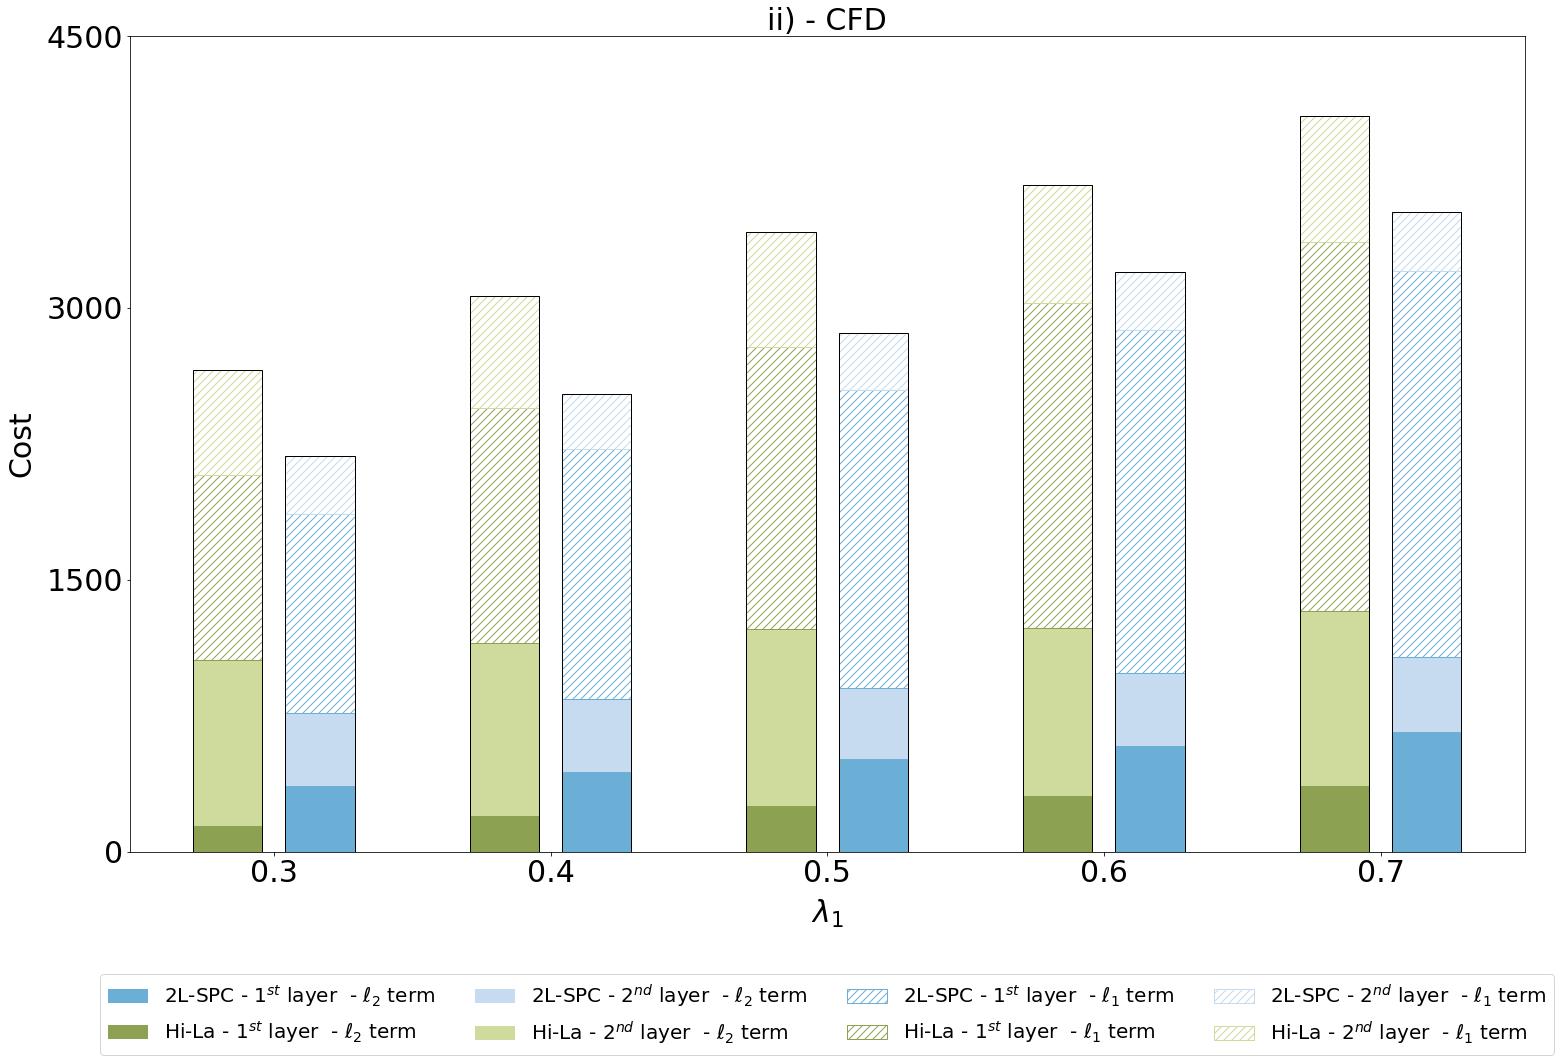

In [92]:
## Just To produce a nice figure for github markdown

save_fig = True
width = 0.75 
fontsize = 20
## Plotting reconsctruction error when increasing lbda1
N = res_exp_lbda1['loss'].shape[1]
position_SDPC = [2 + 3*i for i in range(N)] 
position_HiLa = [1 + 3*i for i in range(N)] 
SPDC_l2norm_L1_lbda1 = res_exp_lbda1['L2_loss'][1,:,0]
SPDC_l2norm_L2_lbda1 = res_exp_lbda1['L2_loss'][1,:,1]
SPDC_l1norm_L1_lbda1 = res_exp_lbda1['L1_loss'][1,:,0]
SPDC_l1norm_L2_lbda1 = res_exp_lbda1['L1_loss'][1,:,1]

HiLa_l2norm_L1_lbda1 = res_exp_lbda1['L2_loss'][0,:,0]
HiLa_l2norm_L2_lbda1 = res_exp_lbda1['L2_loss'][0,:,1]
HiLa_l1norm_L1_lbda1 = res_exp_lbda1['L1_loss'][0,:,0]
HiLa_l1norm_L2_lbda1 = res_exp_lbda1['L1_loss'][0,:,1]


fig = plt.figure(figsize=(25,15))

p_SDPC__l2norm_L1 = plt.bar(position_SDPC, SPDC_l2norm_L1_lbda1,
                    width, color=cmap1(1))
p_SDPC_l2norm_L2 = plt.bar(position_SDPC, SPDC_l2norm_L2_lbda1,
                    width, color=cmap1(3),bottom= SPDC_l2norm_L1_lbda1)
                   
p_SDPC_l1norm_L1= plt.bar(position_SDPC, SPDC_l1norm_L1_lbda1,
                    width, bottom=SPDC_l2norm_L2_lbda1+SPDC_l2norm_L1_lbda1,color='white'
                           ,edgecolor=cmap1(1), hatch='///')

p_SDPC_l1norm_L2 = plt.bar(position_SDPC, SPDC_l1norm_L2_lbda1,
                    width, bottom=SPDC_l2norm_L2_lbda1+SPDC_l2norm_L1_lbda1+SPDC_l1norm_L1_lbda1,
                           color='white',edgecolor=cmap1(3), hatch='///')


p_edges_SDPC = plt.bar(position_SDPC, SPDC_l2norm_L1_lbda1+SPDC_l2norm_L2_lbda1+SPDC_l1norm_L2_lbda1+SPDC_l1norm_L1_lbda1,
                    width,color='none',edgecolor='black')

p_HiLa_l2norm_L1 = plt.bar(position_HiLa, HiLa_l2norm_L1_lbda1, width ,color=cmap2(5))
p_HiLa_l2norm_L2 = plt.bar(position_HiLa, HiLa_l2norm_L2_lbda1, width, color=cmap2(7),
                   bottom=HiLa_l2norm_L1_lbda1)
p_HiLa_l1norm_L1 = plt.bar(position_HiLa, HiLa_l1norm_L1_lbda1, width, color='white',
                   bottom=HiLa_l2norm_L1_lbda1+HiLa_l2norm_L2_lbda1, edgecolor=cmap2(5),
                    hatch='///')
p_HiLa_l1norm_L2 = plt.bar(position_HiLa, HiLa_l1norm_L2_lbda1, width, color='white',
                   bottom=HiLa_l2norm_L1_lbda1+HiLa_l2norm_L2_lbda1+HiLa_l1norm_L1_lbda1,
                    edgecolor=cmap2(7), hatch='///')

p_edges_HiLa = plt.bar(position_HiLa, HiLa_l2norm_L1_lbda1+HiLa_l2norm_L2_lbda1+HiLa_l1norm_L2_lbda1+HiLa_l1norm_L1_lbda1,
                    width,color='none',edgecolor='black')


plt.ylabel('Cost', fontsize=30, labelpad=10)
plt.title('ii) - CFD', fontsize=30)
xticks_position = [1.5 +3*i for i in range(N)]
plt.xlabel(r"$\lambda_{1}$", fontsize=30, labelpad=10)
plt.yticks([0,1500,3000,4500],fontsize=30)
plt.xticks(xticks_position,['{0:0.1f}'.format(lbda1) for lbda1 in range_lbda1]
           , fontsize=30)

plt.legend((p_SDPC_l2norm_L1, p_HiLa_l2norm_L1, p_SDPC_l2norm_L2, p_HiLa_l2norm_L2,
           p_SDPC_l1norm_L1, p_HiLa_l1norm_L1, p_SDPC_l1norm_L2,  p_HiLa_l1norm_L2), 
          ('2L-SPC - '+ r'$1^{st}$'+' layer  - 'r'$\ell_2$' +' term',
           'Hi-La - '+ r'$1^{st}$'+' layer  - 'r'$\ell_2$' +' term',
           '2L-SPC - '+ r'$2^{nd}$'+' layer  - 'r'$\ell_2$' +' term', 
           'Hi-La - '+ r'$2^{nd}$'+' layer  - 'r'$\ell_2$' +' term',
           '2L-SPC - '+ r'$1^{st}$'+' layer  - 'r'$\ell_1$' +' term',
           'Hi-La - '+ r'$1^{st}$'+' layer  - 'r'$\ell_1$' +' term',
           '2L-SPC - '+ r'$2^{nd}$'+' layer  - 'r'$\ell_1$' +' term',
           'Hi-La - '+ r'$2^{nd}$'+' layer  - 'r'$\ell_1$' +' term'),
          ncol=4, 
           bbox_to_anchor=(0.5, -0.2), 
           loc='center',
           fontsize=fontsize)

if save_fig:
    plt.savefig('Savings/Fig/Fig2/Fig2-a-ii.png', bbox_inches = 'tight', pad_inches = 0.1)
    
plt.show()



In [93]:
## Compute variation 

SPDC_l2norm_L1_lbda1 = res_exp_lbda1['L2_loss'][1,:,0]
HiLa_l2norm_L1_lbda1 = res_exp_lbda1['L2_loss'][0,:,0]
SPDC_l2norm_L2_lbda1 = res_exp_lbda1['L2_loss'][1,:,1]
HiLa_l2norm_L2_lbda1 = res_exp_lbda1['L2_loss'][0,:,1]

print('QUADRATIC COST')
var = ((SPDC_l2norm_L1_lbda1/HiLa_l2norm_L1_lbda1) - 1).mean()
print('1st layer SDPC/HiLa (average) : {0:2} %'.format(var*100))

var = ((SPDC_l2norm_L2_lbda1/HiLa_l2norm_L2_lbda1) - 1).mean()
print('2nd layer SDPC/HiLa (average) : {0:2} %'.format(var*100))

var = ((HiLa_l2norm_L1_lbda1[-1]/HiLa_l2norm_L1_lbda1[0]) - 1)
print('First Layer HiLa high_lbda_1 / low_lbda_1 : {0:0.2f} %'.format(var*100))

var = ((SPDC_l2norm_L1_lbda1[-1]/SPDC_l2norm_L1_lbda1[0]) - 1)
print('First Layer SDPC high_lbda_1 / low_lbda_1 : {0:0.2f} %'.format(var*100))


print('SPARSITY COST')

SPDC_l1norm_L1_lbda1 = res_exp_lbda1['L1_loss'][1,:,0]
HiLa_l1norm_L1_lbda1 = res_exp_lbda1['L1_loss'][0,:,0]
SPDC_l1norm_L2_lbda1 = res_exp_lbda1['L1_loss'][1,:,1]
HiLa_l1norm_L2_lbda1 = res_exp_lbda1['L1_loss'][0,:,1]

var = ((HiLa_l1norm_L1_lbda1[-1]/HiLa_l1norm_L1_lbda1[0]) - 1)
print('First Layer HiLa high_lbda_1 / low_lbda_1 : {0:0.2f} %'.format(var*100))

var = ((SPDC_l1norm_L1_lbda1[-1]/SPDC_l1norm_L1_lbda1[0]) - 1)
print('First Layer SDPC high_lbda_1 / low_lbda_1 : {0:0.2f} %'.format(var*100))


print('QUADRATIC COST')

SPDC_l1norm_L1_lbda2 = res_exp_lbda2['L2_loss'][1,:,0]
HiLa_l1norm_L1_lbda2 = res_exp_lbda2['L2_loss'][0,:,0]
SPDC_l1norm_L2_lbda2 = res_exp_lbda2['L2_loss'][1,:,1]
HiLa_l1norm_L2_lbda2 = res_exp_lbda2['L2_loss'][0,:,1]

var = ((HiLa_l1norm_L1_lbda2[-1]/HiLa_l1norm_L1_lbda2[0]) - 1)
print('First Layer HiLa high_lbda_2 / low_lbda_2 : {0:0.2f} %'.format(var*100))

var = ((SPDC_l1norm_L1_lbda2[-1]/SPDC_l1norm_L1_lbda2[0]) - 1)
print('First Layer SDPC high_lbda_2 / low_lbda_2 : {0:0.2f} %'.format(var*100))

'''

print('SPARSITY COST')

SPDC_l1norm_L1_lbda2 = res_exp_lbda2['L2_loss'][1,:,0]
HiLa_l1norm_L1_lbda2 = res_exp_lbda2['L2_loss'][0,:,0]
SPDC_l1norm_L2_lbda2 = res_exp_lbda2['L2_loss'][1,:,1]
HiLa_l1norm_L2_lbda2 = res_exp_lbda2['L2_loss'][0,:,1]

var = ((HiLa_l1norm_L1_lbda2[-1]/HiLa_l1norm_L1_lbda2[0]) - 1)
print('First Layer HiLa high_lbda_1 / low_lbda_1 : {0:0.2f} %'.format(var*100))

var = ((SPDC_l1norm_L1_lbda2[-1]/SPDC_l1norm_L1_lbda2[0]) - 1)
print('First Layer SDPC high_lbda_1 / low_lbda_1 : {0:0.2f} %'.format(var*100))

var = ((HiLa_l1norm_L2_lbda2[-1]/HiLa_l1norm_L2_lbda2[0]) - 1)
print('Second Layer HiLa high_lbda_1 / low_lbda_1 : {0:0.2f} %'.format(var*100))

var = ((SPDC_l1norm_L2_lbda2[-1]/SPDC_l1norm_L2_lbda2[0]) - 1)
print('Second Layer SDPC high_lbda_1 / low_lbda_1 : {0:0.2f} %'.format(var*100))
'''

QUADRATIC COST
1st layer SDPC/HiLa (average) : 110.31300224281632 %
2nd layer SDPC/HiLa (average) : -57.553215321735586 %
First Layer HiLa high_lbda_1 / low_lbda_1 : 152.70 %
First Layer SDPC high_lbda_1 / low_lbda_1 : 83.34 %
SPARSITY COST
First Layer HiLa high_lbda_1 / low_lbda_1 : 99.99 %
First Layer SDPC high_lbda_1 / low_lbda_1 : 93.87 %
QUADRATIC COST
First Layer HiLa high_lbda_2 / low_lbda_2 : -0.36 %
First Layer SDPC high_lbda_2 / low_lbda_2 : 16.48 %


"\n\nprint('SPARSITY COST')\n\nSPDC_l1norm_L1_lbda2 = res_exp_lbda2['L2_loss'][1,:,0]\nHiLa_l1norm_L1_lbda2 = res_exp_lbda2['L2_loss'][0,:,0]\nSPDC_l1norm_L2_lbda2 = res_exp_lbda2['L2_loss'][1,:,1]\nHiLa_l1norm_L2_lbda2 = res_exp_lbda2['L2_loss'][0,:,1]\n\nvar = ((HiLa_l1norm_L1_lbda2[-1]/HiLa_l1norm_L1_lbda2[0]) - 1)\nprint('First Layer HiLa high_lbda_1 / low_lbda_1 : {0:0.2f} %'.format(var*100))\n\nvar = ((SPDC_l1norm_L1_lbda2[-1]/SPDC_l1norm_L1_lbda2[0]) - 1)\nprint('First Layer SDPC high_lbda_1 / low_lbda_1 : {0:0.2f} %'.format(var*100))\n\nvar = ((HiLa_l1norm_L2_lbda2[-1]/HiLa_l1norm_L2_lbda2[0]) - 1)\nprint('Second Layer HiLa high_lbda_1 / low_lbda_1 : {0:0.2f} %'.format(var*100))\n\nvar = ((SPDC_l1norm_L2_lbda2[-1]/SPDC_l1norm_L2_lbda2[0]) - 1)\nprint('Second Layer SDPC high_lbda_1 / low_lbda_1 : {0:0.2f} %'.format(var*100))\n"

## Fig 4

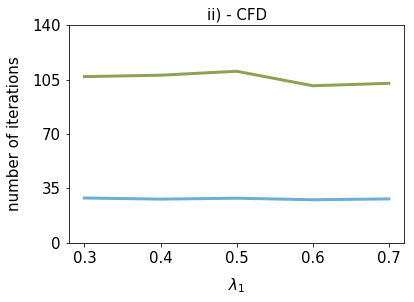

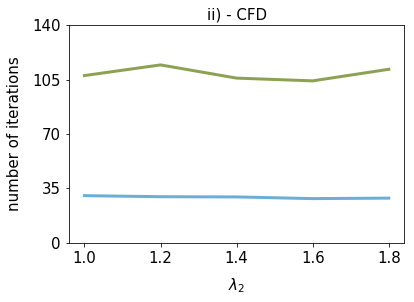

In [94]:
## Plotting the curve
save_fig =  False

med_lbda1_SDPC = res_exp_lbda1['it'][1,:]
med_lbda1_HiLa = res_exp_lbda1['it'][0,:]

out = plt.plot(range_lbda1, med_lbda1_SDPC, label='SDPC', color=cmap1(1), linewidth=3)
out = plt.plot(range_lbda1, med_lbda1_HiLa, label='Hi-La', color=cmap2(5), linewidth=3)
plt.xticks(range_lbda1,fontsize=15)
plt.yticks([0,35,70,105,140], fontsize=15)

plt.tick_params(axis='both', which='major', pad=5)
plt.title('ii) - CFD', fontsize=15)
out = plt.xlabel(r"$\lambda_{1}$", fontsize=15, labelpad=10)
out = plt.ylabel("number of iterations", fontsize=15, labelpad=10)

if save_fig:

    plt.savefig('Figure/CFD_nbit_lbda1.png', bbox_inches = 'tight', pad_inches = 0.1, dpi=400)


plt.show()


med_lbda2_SDPC = res_exp_lbda2['it'][1,:]
med_lbda2_HiLa = res_exp_lbda2['it'][0,:]

out = plt.plot(range_lbda2, med_lbda2_SDPC, label='SDPC', color=cmap1(1), linewidth=3)
out = plt.plot(range_lbda2, med_lbda2_HiLa, label='Hi-La', color=cmap2(5), linewidth=3)
plt.xticks(range_lbda2,fontsize=15)
plt.yticks([0,35,70,105,140], fontsize=15)

plt.tick_params(axis='both', which='major', pad=5)
plt.title('ii) - CFD', fontsize=15)
out = plt.xlabel(r"$\lambda_{2}$", fontsize=15, labelpad=10)
out = plt.ylabel("number of iterations", fontsize=15, labelpad=10)

if save_fig:

    plt.savefig('Figure/CFD_nbit_lbda2png', bbox_inches = 'tight', pad_inches = 0.1, dpi=400)

plt.show()


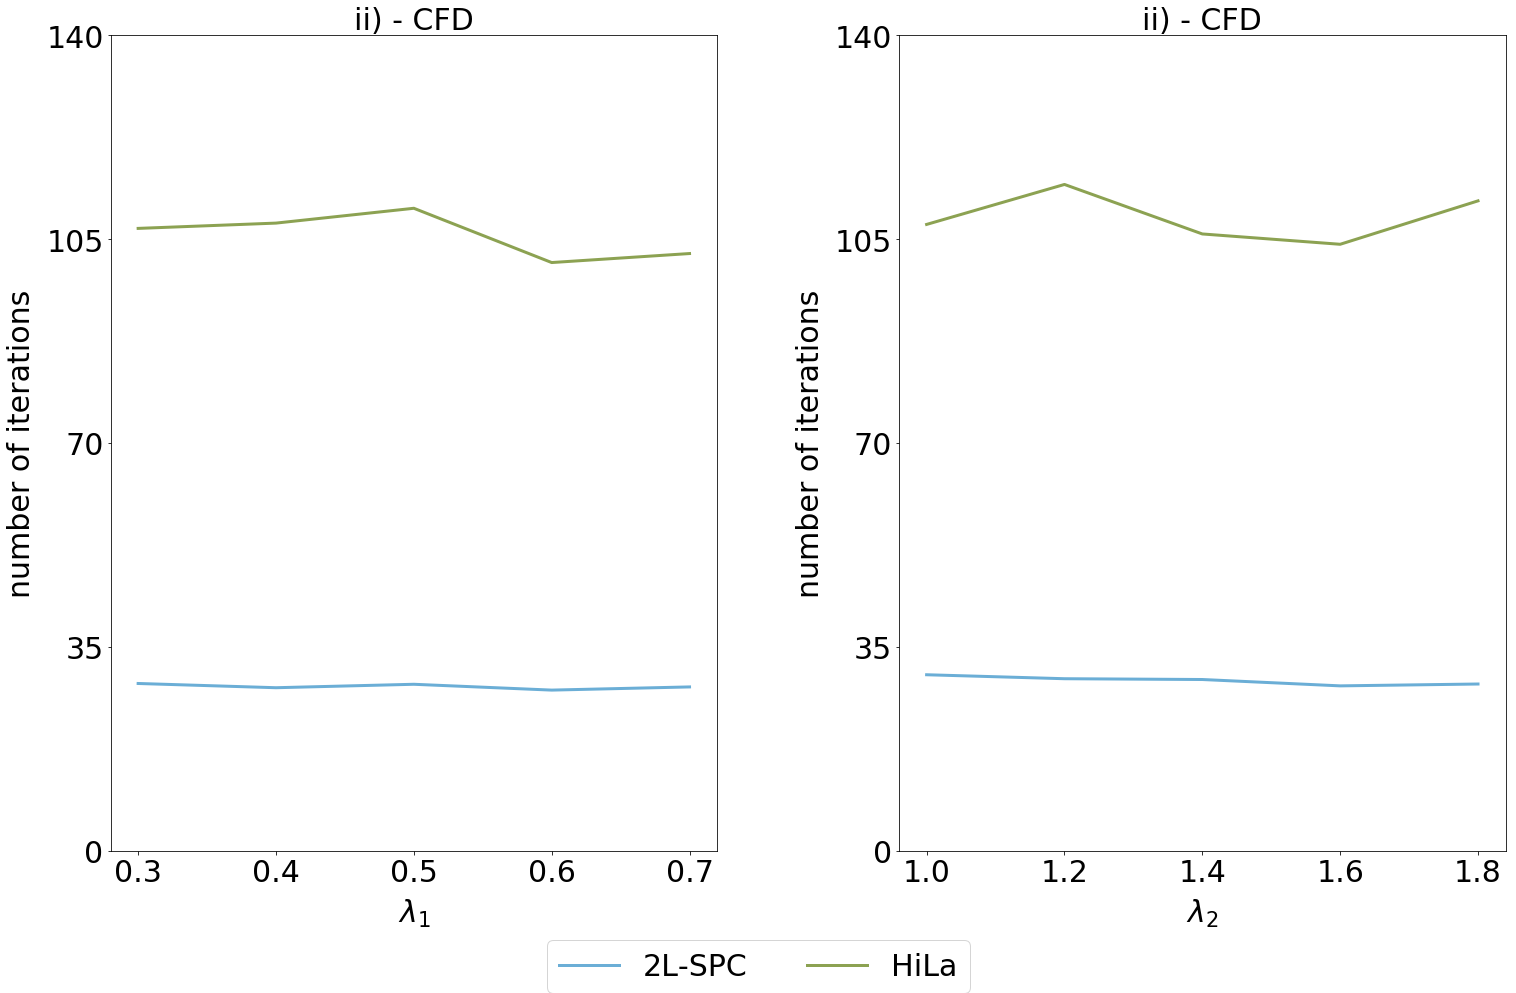

In [146]:
## Just To produce a nice figure for github markdown

save_fig = True
width = 0.75 
fontsize = 30
## Plotting reconsctruction error when increasing lbda1

#fig, ax = plt.subplot()
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(25,15))
#fig = plt.figure(figsize=(25,15))

print(axs)
med_lbda1_SDPC = res_exp_lbda1['it'][1,:]
med_lbda1_HiLa = res_exp_lbda1['it'][0,:]

out1 = axs[0].plot(range_lbda1, med_lbda1_SDPC, label='SDPC', color=cmap1(1), linewidth=3)
out2 = axs[0].plot(range_lbda1, med_lbda1_HiLa, label='Hi-La', color=cmap2(5), linewidth=3)


axs[0].set_xticks([0.3,0.4,0.5,0.6,0.7])
axs[0].set_yticks([0,35,70,105,140])

axs[0].set_xticklabels([0.3,0.4,0.5,0.6,0.7],fontsize=fontsize)
axs[0].set_yticklabels([0,35,70,105,140], fontsize=fontsize)

axs[0].set_xlabel(r"$\lambda_{1}$", fontsize=fontsize, labelpad=10)
axs[0].set_ylabel("number of iterations", fontsize=fontsize, labelpad=10)

axs[0].set_title('ii) - CFD', fontsize=fontsize)


med_lbda2_SDPC = res_exp_lbda2['it'][1,:]
med_lbda2_HiLa = res_exp_lbda2['it'][0,:]

out = axs[1].plot(range_lbda2, med_lbda2_SDPC, label='2L-SPC', color=cmap1(1), linewidth=3)
out = axs[1].plot(range_lbda2, med_lbda2_HiLa, label='Hi-La', color=cmap2(5), linewidth=3)

axs[1].set_xticks([1.0,1.2,1.4,1.6,1.8])
axs[1].set_yticks([0,35,70,105,140])

axs[1].set_xticklabels([1.0,1.2,1.4,1.6,1.8],fontsize=fontsize)
axs[1].set_yticklabels([0,35,70,105,140], fontsize=fontsize)

axs[1].set_xlabel(r"$\lambda_{2}$", fontsize=fontsize, labelpad=10)
axs[1].set_ylabel("number of iterations", fontsize=fontsize, labelpad=10)

axs[1].set_title('ii) - CFD', fontsize=30)

fig.legend([out1,out2],
          labels=['2L-SPC','HiLa'],
          fontsize=fontsize,
          loc="lower center",   # Position of legend
         borderaxespad=0,    # Small spacing around legend box
          ncol=2)

plt.subplots_adjust(wspace=0.3,hspace=0.3)
#plt.xticks(range_lbda2,fontsize=15)
#plt.yticks([0,35,70,105,140], fontsize=15)

#plt.tick_params(axis='both', which='major', pad=5)
#plt.title('ii) - CFD', fontsize=15)
#out = plt.xlabel(r"$\lambda_{2}$", fontsize=15, labelpad=10)
#out = plt.ylabel("number of iterations", fontsize=15, labelpad=10)

if save_fig:

    plt.savefig('Savings/Fig/Fig4-a_and_b-ii.png', bbox_inches = 'tight', pad_inches = 0.1)

#plt.show()








## Fig 3

In [9]:
range_lbda1 = [0.3 + i*0.1 for i in range(5)] ## range of tested lbda1
range_lbda2 = [1.0 + i*0.2 for i in range(5)] 
list_exp_b0 = [['CFD_[{0:0.1f},{1:0.1f}]_b=0'.format(lbda1,lbda2) \
                for lbda2 in range_lbda2] \
               for lbda1 in range_lbda1]
list_exp_b1 = [['CFD_[{0:0.1f},{1:0.1f}]_b=1'.format(lbda1,lbda2) \
                for lbda2 in range_lbda2] \
               for lbda1 in range_lbda1]

In [10]:
save = False
if save == True :
    file_to_save = 'Savings/CFD/HM_b=0.pkl'
    Loss_t = [torch.zeros(len(list_exp_b0[0]),len(list_exp_b0)),
                 torch.zeros(len(list_exp_b0[0]),len(list_exp_b0))]
    size_line = len(list_exp_b0[0])-1
    for idx_col, all_col in enumerate(list_exp_b0):
        for idx_line, model_name in enumerate(list_exp_b0[idx_col]):
            path = 'Savings/CFD/' + model_name + '.pkl'
            print('opening path :',path)
            with open(path, 'rb') as file:
                out = pickle.load(file)
            Net = out['Net']
            Loss = out['Loss']
            Pursuit = out['Pursuit']
            all_Loss = [0] * (Net.nb_layers)
            all_penalty = [0] * (Net.nb_layers)
            for idx_batch, data in enumerate(Facedata.data):
                batch = data[0].cuda()
                gamma, it, Loss_G, delta = Pursuit.coding(batch)
                for i in range(Net.nb_layers):
                    all_Loss[i] += Loss.F(batch,gamma,i, do_feedback=False).div(batch.size()[0])
                penalty = [Loss.lambdas[i]*gamma[i].abs().sum() for i in range(Net.nb_layers)]
                for i in range(Net.nb_layers):
                    all_penalty[i] += penalty[i]
                #if idx_batch == 2:
                #    break
            for i in range(Net.nb_layers):
                all_Loss[i] /= ((idx_batch+1))    
            for i in range(Net.nb_layers):
                all_penalty[i] /= ((idx_batch+1)*batch.size(0))    
            for i in range(Net.nb_layers):
                Loss_t[i][size_line - idx_line,idx_col] = all_Loss[i].cpu() + all_penalty[i].cpu()
    res_exp = {'loss': Loss_t}
    with open(file_to_save, 'wb') as file:
        pickle.dump(res_exp, file, pickle.HIGHEST_PROTOCOL)
        
    file_to_save = 'Savings/CFD/HM_b=1.pkl'
    Loss_t = [torch.zeros(len(list_exp_b1[0]),len(list_exp_b1)),
                 torch.zeros(len(list_exp_b1[0]),len(list_exp_b1))]
    size_line = len(list_exp_b1[0])-1
    for idx_col, all_col in enumerate(list_exp_b0):
        for idx_line, model_name in enumerate(list_exp_b1[idx_col]):
            path = 'Savings/CFD/' + model_name + '.pkl'
            print('opening path :',path)
            with open(path, 'rb') as file:
                out = pickle.load(file)
            Net = out['Net']
            Loss = out['Loss']
            Pursuit = out['Pursuit']
            all_Loss = [0] * (Net.nb_layers)
            all_penalty = [0] * (Net.nb_layers)
            for idx_batch, data in enumerate(Facedata.data):
                batch = data[0].cuda()
                gamma, it, Loss_G, delta = Pursuit.coding(batch)
                for i in range(Net.nb_layers):
                    all_Loss[i] += Loss.F(batch,gamma,i, do_feedback=False).div(batch.size()[0])
                penalty = [Loss.lambdas[i]*gamma[i].abs().sum() for i in range(Net.nb_layers)]
                for i in range(Net.nb_layers):
                    all_penalty[i] += penalty[i]
                if idx_batch == 2:
                    break
            for i in range(Net.nb_layers):
                all_Loss[i] /= ((idx_batch+1))    
            for i in range(Net.nb_layers):
                all_penalty[i] /= ((idx_batch+1)*batch.size(0))    
            for i in range(Net.nb_layers):
                Loss_t[i][size_line - idx_line,idx_col] = all_Loss[i].cpu() + all_penalty[i].cpu()
    res_exp = {'loss': Loss_t}
    with open(file_to_save, 'wb') as file:
        pickle.dump(res_exp, file, pickle.HIGHEST_PROTOCOL)

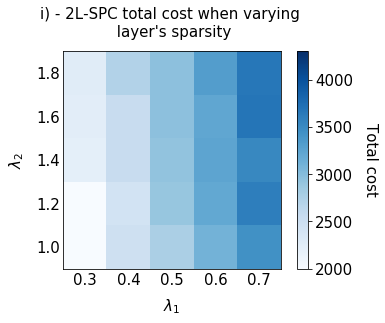

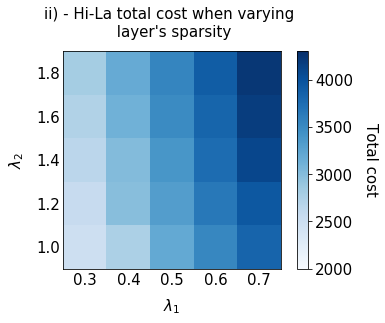

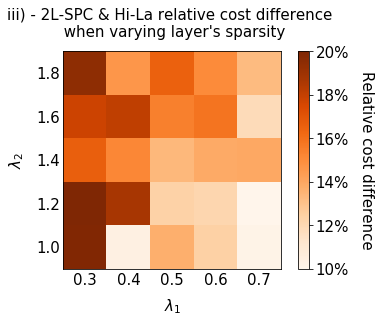

In [11]:
save_fig = False

#print(model_name_list)
name_x=['0.3','0.4','0.5','0.6','0.7']
name_y=['1.8','1.6','1.4','1.2','1.0']
cbar_ticks=['2000','2500','3000','3500','4000']

## Loading HeatMaps
with open('Savings/CFD/HM_b=1.pkl', 'rb') as file:
    HM_b1 = pickle.load(file)
    
with open('Savings/CFD/HM_b=0.pkl', 'rb') as file:
    HM_b0 = pickle.load(file)


HM_b1_tot = HM_b1['loss'][0] + HM_b1['loss'][1]
HM_b0_tot = HM_b0['loss'][0] + HM_b0['loss'][1]

fig = plt.figure()
out = plt.imshow(HM_b1_tot, cmap='Blues', vmin=2000, vmax=4300)

plt.xticks([0,1,2,3,4], name_x,fontsize=15)
plt.yticks([0,1,2,3,4], name_y, fontsize=15)
plt.tick_params(axis='both', which='both', length=0)
out1 = plt.xlabel(r"$\lambda_{1}$", fontsize=15, labelpad=10)
out1 = plt.ylabel(r"$\lambda_{2}$", fontsize=15, labelpad=10)
plt.title('i) - 2L-SPC total cost when varying \n layer\'s sparsity', fontsize=15, pad=15)

cbar = fig.colorbar(out)
cbar.ax.set_ylabel('Total cost', rotation=-90, va="bottom",fontsize=15,labelpad=10)
cbar.ax.set_yticklabels([2000,2500,3000,3500,4000],fontsize=15)
#cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)

if save_fig == True:
    plt.tight_layout()
    plt.savefig('Figure/HM_GlobalLoss_b1',dpi=400, bbox_inches = 'tight',
    pad_inches = 0)
    
plt.show()

fig = plt.figure()
out = plt.imshow(HM_b0_tot, cmap='Blues', vmin=2000, vmax=4300)

plt.xticks([0,1,2,3,4], name_x,fontsize=15)
plt.yticks([0,1,2,3,4], name_y, fontsize=15)
plt.tick_params(axis='both', which='both', length=0)
out1 = plt.xlabel(r"$\lambda_{1}$", fontsize=15, labelpad=10)
out1 = plt.ylabel(r"$\lambda_{2}$", fontsize=15, labelpad=10)
plt.title('ii) - Hi-La total cost when varying \n layer\'s sparsity', fontsize=15, pad=15)
cbar = fig.colorbar(out)
lab = cbar.ax.set_ylabel('Total cost', rotation=-90, va="bottom",fontsize=15,labelpad=10)
lab = cbar.ax.set_yticklabels([2000,2500,3000,3500,4000],fontsize=15)

if save_fig == True:
    plt.tight_layout()
    plt.savefig('Figure/HM_GlobalLoss_b0',dpi=400, bbox_inches = 'tight',
    pad_inches = 0)

plt.show()
    
HM_relative_error = (HM_b0_tot - HM_b1_tot)/HM_b0_tot
fig = plt.figure()
out = plt.imshow(HM_relative_error, cmap='Oranges',vmin=0.10,vmax=0.2)

plt.xticks([0,1,2,3,4], name_x,fontsize=15)
plt.yticks([0,1,2,3,4], name_y, fontsize=15)
plt.tick_params(axis='both', which='both', length=0)
out1 = plt.xlabel(r"$\lambda_{1}$", fontsize=15, labelpad=10)
out1 = plt.ylabel(r"$\lambda_{2}$", fontsize=15, labelpad=10)
plt.title('iii) - 2L-SPC & Hi-La relative cost difference \n when varying layer\'s sparsity', fontsize=15, pad=15)

cbar = fig.colorbar(out)
lab = cbar.ax.set_ylabel('Relative cost difference', rotation=-90, va="bottom",fontsize=15,labelpad=10)
lab = cbar.ax.set_yticklabels(['10%','12%','14%','16%','18%','20%'],fontsize=15)
if save_fig == True:
    plt.tight_layout()
    plt.savefig('Figure/HM_Relative',dpi=400, bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

## Fig 6

In [137]:
path = 'Savings/CFD/CFD_[0.5,1.8]_b=0.pkl'
with open(path, 'rb') as file:
    res_Hila = pickle.load(file)

path = 'Savings/CFD/CFD_[0.5,1.8]_b=1.pkl'
with open(path, 'rb') as file:
    res_SDPC = pickle.load(file)

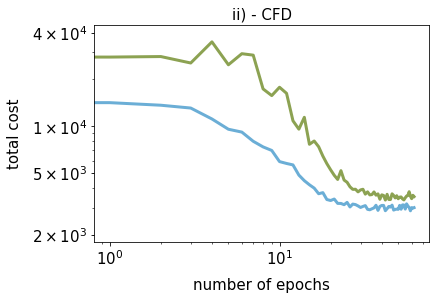

In [139]:
save_fig = False
fig1, ax1 = plt.subplots()

x  = np.arange(10,2500,20)
idx = np.arange(10,25000,400)

reco_Hila = res_Hila['l2_loss'][0] + 0.5*res_Hila['l1_loss'][0] + \
            res_Hila['l2_loss'][1] + 1.8*res_Hila['l1_loss'][1]
reco_SDPC = res_SDPC['l2_loss'][0] + 0.5*res_SDPC['l1_loss'][0] + \
            res_SDPC['l2_loss'][1] + 1.8*res_SDPC['l1_loss'][1]

out = ax1.plot(reco_SDPC[idx].detach().numpy(), label = '2L_SPC', color=cmap1(1), linewidth=3)
out = ax1.plot(reco_Hila[idx].detach().numpy(), label='Hi-La', color=cmap2(5), linewidth=3)

ax1.set_title('ii) - CFD', fontsize=15)

ax1.set_xticks([0,500,1000,1500,2000,2500])
ax1.set_xticklabels([0,50,100,150,200,250],fontsize=15)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_yticks([2000, 5000,10000,40000])

ax1.set_ylim([1800, 45000])
ax1.set_yticklabels([r'$2\times10^3$',r'$5\times10^3$',r'$1\times10^4$', r'$4\times10^4$'],fontsize=15)
out = ax1.set_xlabel("number of epochs", fontsize=15, labelpad=10)
out = ax1.set_ylabel("total cost", fontsize=15, labelpad=10)

if save_fig :
    plt.savefig('Figure/STL10_Loss_training.png', bbox_inches = 'tight', pad_inches = 0.1, dpi=400)

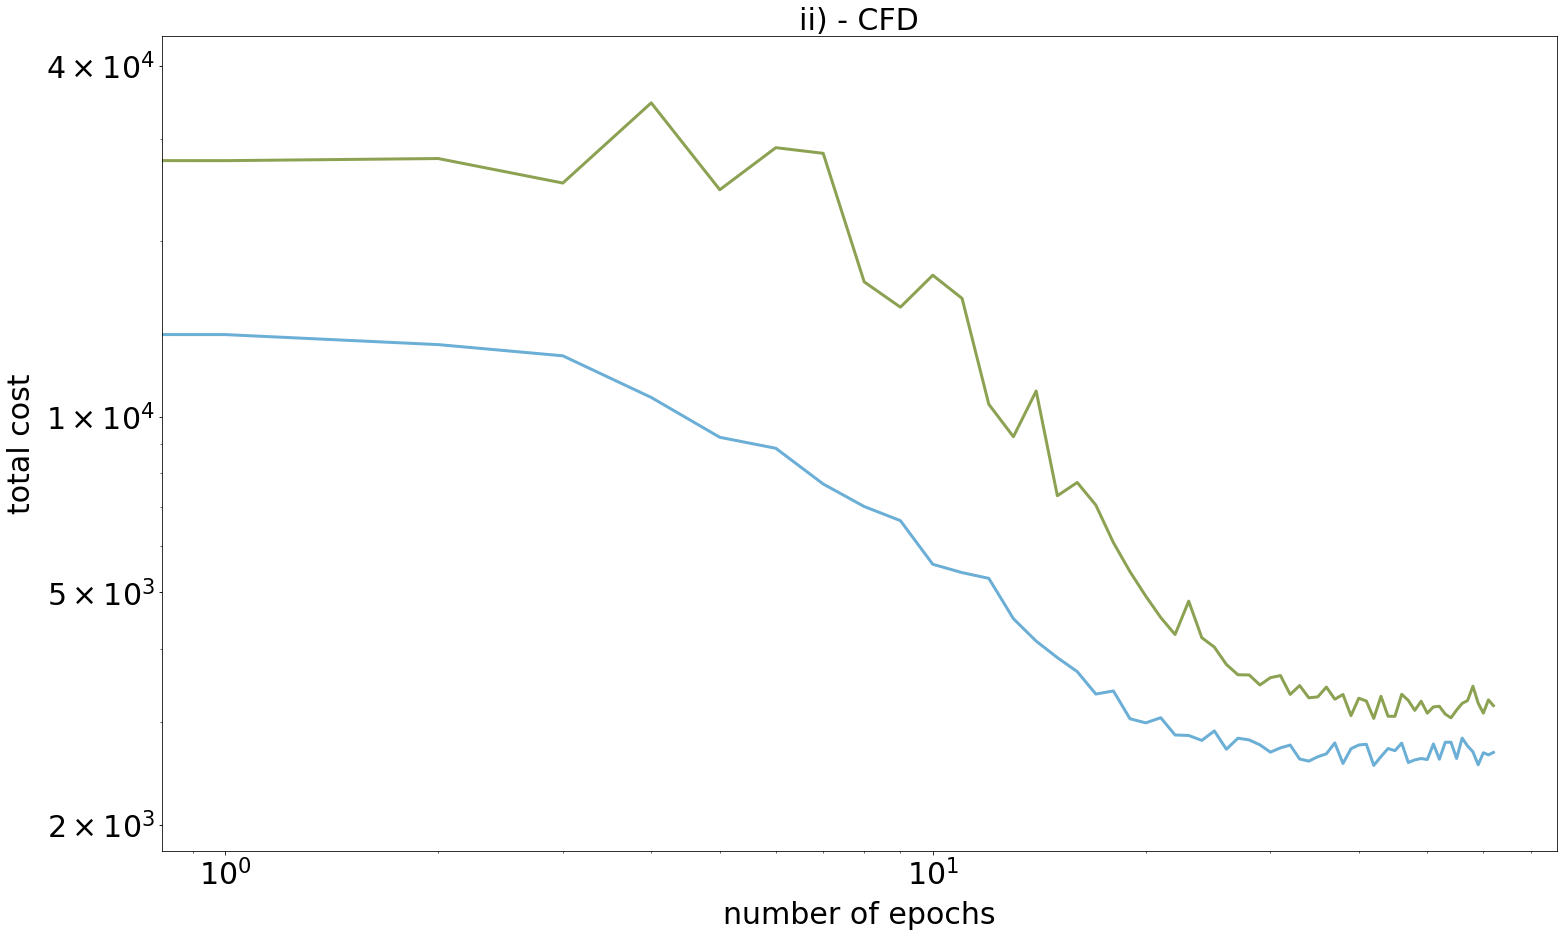

In [145]:
## Just To produce a nice figure for github markdown

save_fig = True
width = 0.75 
fontsize = 30
## Plotting reconsctruction error when increasing lbda1

x  = np.arange(10,2500,20)
idx = np.arange(10,25000,400)

reco_Hila = res_Hila['l2_loss'][0] + 0.4*res_Hila['l1_loss'][0] + \
            res_Hila['l2_loss'][1] + 1.8*res_Hila['l1_loss'][1]
reco_SDPC = res_SDPC['l2_loss'][0] + 0.4*res_SDPC['l1_loss'][0] + \
            res_SDPC['l2_loss'][1] + 1.8*res_SDPC['l1_loss'][1]

fig, ax1 = plt.subplots(nrows=1,ncols=1,figsize=(25,15))

out = ax1.plot(reco_SDPC[idx].detach().numpy(), label = '2L_SPC', color=cmap1(1), linewidth=3)
out = ax1.plot(reco_Hila[idx].detach().numpy(), label='Hi-La', color=cmap2(5), linewidth=3)

#fig1, ax1 = plt.subplots()

ax1.set_title('ii) - CFD', fontsize=fontsize)

ax1.set_xticks([0,500,1000,1500,2000,2500])
ax1.set_xticklabels([0,50,100,150,200,250],fontsize=fontsize)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_yticks([2000, 5000,10000,40000])

ax1.set_ylim([1800, 45000])
ax1.set_yticklabels([r'$2\times10^3$',r'$5\times10^3$',r'$1\times10^4$', r'$4\times10^4$'],fontsize=fontsize)
out = ax1.set_xlabel("number of epochs", fontsize=fontsize, labelpad=10)
out = ax1.set_ylabel("total cost", fontsize=fontsize, labelpad=10)


if save_fig:

    plt.savefig('Savings/Fig/Fig6-ii.png', bbox_inches = 'tight', pad_inches = 0.1)
    
    








torch.Size([84])

84

tensor([26086.4941, 13756.4424, 13220.3467, 12673.5938, 10707.6631,  9195.3047,
         8844.9355,  7689.8433,  7049.0967,  6678.6943,  5676.9468,  5541.9277,
         5434.3320,  4679.7812,  4319.9180,  4083.1619,  3898.2712,  3590.4912,
         3663.0176,  3311.8940,  3267.5618,  3347.2551,  3140.4910,  3140.7720,
         3084.9058,  3191.9697,  2983.2268,  3116.4143,  3092.5537,  3030.4121,
         2963.7761,  3010.7935,  3050.3967,  2883.7881,  2865.1208,  2908.8782,
         2947.7847,  3067.7283,  2840.2932,  3014.6172,  3059.8936,  3061.7188,
         2826.5759,  2911.7729,  3013.0852,  2984.1116,  3074.0356,  2854.7393,
         2883.1997,  2896.0518,  2884.1272,  3061.5303,  2891.6213,  3084.5129,
         3082.1663,  2898.6853,  3136.0371,  3037.0894,  2964.9932,  2826.2800,
         2961.8408,  2937.0752,  2960.3354])
tensor([143440.4531,  26801.4141,  27065.3398,  24537.8105,  33728.2930,
         23882.0117,  28339.2930,  27788.1191,  16587.6250,  14985.6416,
         